## DB 보험금융공모전

## EDA - First Data Set

In [99]:
import pandas as pd
import numpy as np

# Null Values
import missingno as msno

# Encoding
from sklearn.preprocessing import LabelEncoder

# Handling Outliers
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# VarianceThreshold
from sklearn.feature_selection import VarianceThreshold

# RFECV
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

# Machine Learning - Preparation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Machine Learning - Optuna
import optuna
from optuna.samplers import TPESampler

# Machine Learning - Feature Importance
from sklearn.inspection import permutation_importance

# Visualization
import matplotlib.pyplot as plt

In [96]:
raw_data = pd.read_csv('./fraud_oracle.csv', encoding='utf-8')

### 01) Target Variable Balance - Fraud_Found_P

In [109]:
fraud_counts = raw_data['FraudFound_P'].value_counts().reset_index()
fraud_counts.rename(columns = {"FraudFound_P" : "Fraud_Label", "count" : "Frequency"})

,Fraud_Label,Frequency
0,0,14497
1,1,923


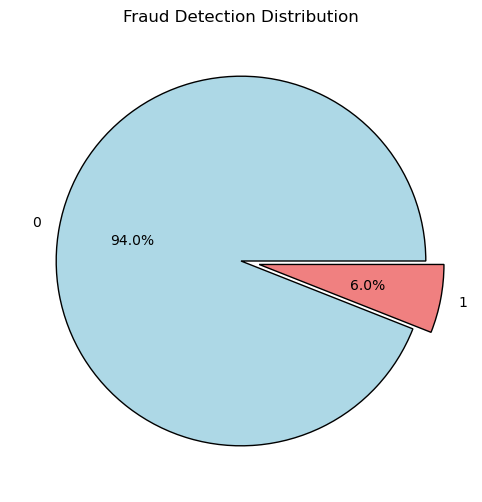

In [114]:
labels = fraud_counts["FraudFound_P"]
counts = fraud_counts["count"]

plt.figure(figsize=(8, 6))  
plt.pie(
    counts, 
    labels=labels, 
    autopct="%1.1f%%", 
    startangle=0,     
    colors=["lightblue", "lightcoral"], 
    explode=(0, 0.1) ,
    wedgeprops={"edgecolor": "black", "linewidth": 1} 
)
plt.title("Fraud Detection Distribution")
plt.show()

# When we see the below pie-plot, We can know that The Target Variable"Fraud_Found_P" is highly imbalanced.

### 02) Fraud Detection by Sex

In [118]:
#Original Data

raw_data['Sex'].value_counts()

Sex
Male      13000
Female     2420
Name: count, dtype: int64

In [136]:
fraud_data = raw_data[raw_data['FraudFound_P'] == 1]
fraud_data

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
28,Jul,1,Saturday,Honda,Urban,Tuesday,Sep,4,Male,Single,...,new,16 to 17,No,No,External,none,no change,1 vehicle,1994,All Perils
52,Jul,3,Sunday,Honda,Rural,Wednesday,Jan,4,Male,Married,...,4 years,26 to 30,No,No,External,3 to 5,no change,1 vehicle,1994,Collision
53,Jul,4,Saturday,Honda,Urban,Wednesday,Aug,2,Male,Married,...,more than 7,41 to 50,No,No,External,3 to 5,no change,1 vehicle,1994,Collision
94,Nov,2,Thursday,Honda,Urban,Friday,Jan,3,Male,Single,...,7 years,31 to 35,No,No,External,3 to 5,no change,1 vehicle,1994,Collision
96,Nov,2,Friday,Toyota,Urban,Tuesday,Jan,1,Male,Married,...,7 years,36 to 40,No,No,External,none,no change,1 vehicle,1994,Collision
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15409,Nov,3,Friday,Mazda,Urban,Sunday,Nov,3,Female,Married,...,7 years,51 to 65,No,No,External,1 to 2,no change,1 vehicle,1996,Collision
15412,Nov,4,Tuesday,Pontiac,Urban,Wednesday,Nov,4,Female,Single,...,5 years,31 to 35,No,No,External,more than 5,no change,1 vehicle,1996,Liability
15415,Nov,4,Friday,Toyota,Urban,Tuesday,Nov,5,Male,Married,...,6 years,31 to 35,No,No,External,none,no change,1 vehicle,1996,Collision
15417,Nov,5,Thursday,Toyota,Rural,Friday,Dec,1,Male,Single,...,5 years,26 to 30,No,No,External,1 to 2,no change,1 vehicle,1996,Collision


In [142]:
fraud_data_sex = fraud_data['Sex'].value_counts().reset_index()
sex_labels = fraud_data_sex['Sex']
sex_sizes = fraud_data_sex['count']

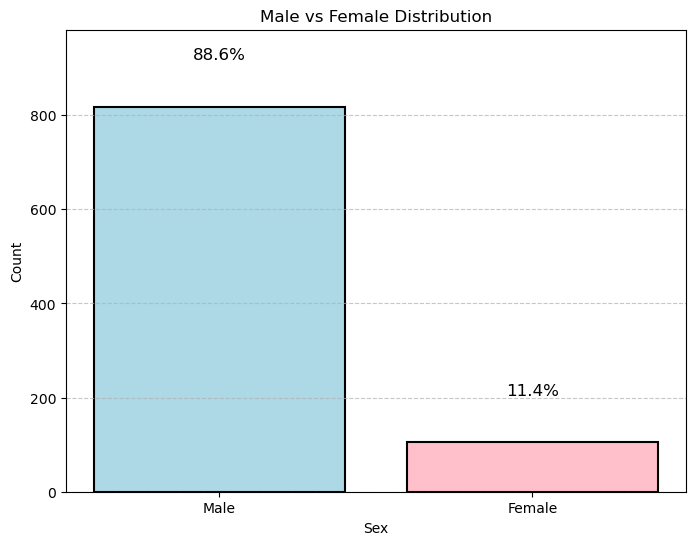

In [155]:
percentage_fraud = [f"{(count / fraud_data.shape[0]) * 100 :.1f}%" for count in fraud_data_sex['count']]

plt.figure(figsize=(8, 6))
bars = plt.bar(sex_labels, sex_sizes, color=["lightblue", "pink"], edgecolor="black", linewidth=1.5)

plt.ylim(0, max(sex_sizes) * 1.2)
for bar, percentage in zip(bars, percentage_fraud):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 100, percentage, ha="center", fontsize=12)

plt.title("Male vs Female Distribution")
plt.ylabel("Count")
plt.xlabel("Sex")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

##### This results suggest that males are significantly more likely to be involved in detected fraud cases compared to females.

### 03) Fraud Detection by Age & Age of Policy Holder

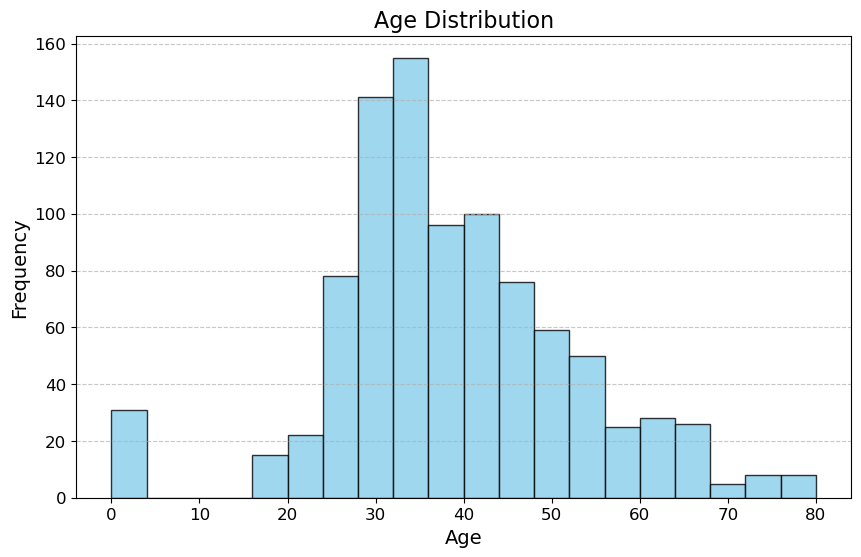

In [156]:
plt.figure(figsize=(10, 6))
plt.hist(fraud_data['Age'], bins=20, color='skyblue', edgecolor='black', alpha=0.8)
plt.title("Age Distribution", fontsize=16)
plt.xlabel("Age", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

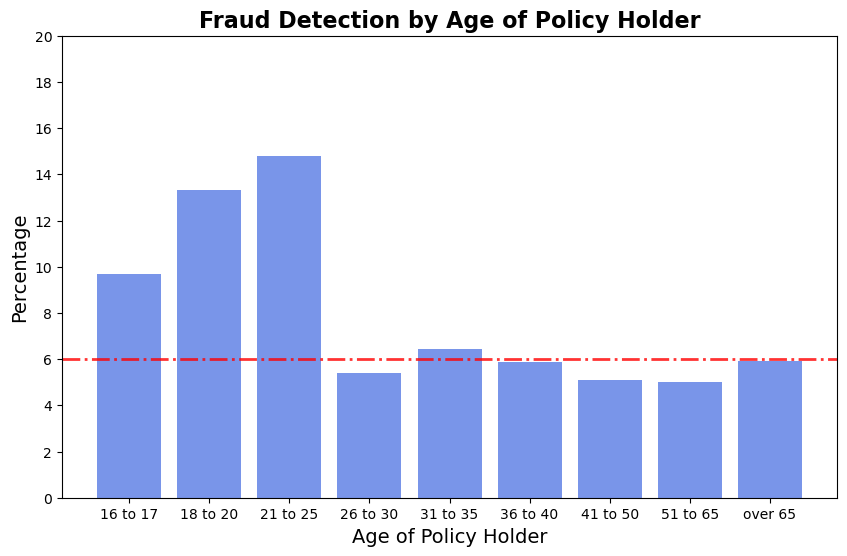

In [160]:
df_fraud = raw_data[raw_data['FraudFound_P'] == 1]
df_non_fraud = raw_data[raw_data['FraudFound_P'] == 0]

df_counts_ageofpolicyholder = raw_data['AgeOfPolicyHolder'].value_counts().sort_index()
df_counts_fraud_ = df_fraud['AgeOfPolicyHolder'].value_counts().sort_index()

df_percentages_fraud_ = round((df_counts_fraud_ / df_counts_ageofpolicyholder) * 100, 2)

fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(df_percentages_fraud_.index, df_percentages_fraud_.values, color='royalblue', alpha=0.7)

ax.set_title('Fraud Detection by Age of Policy Holder', fontsize=16, fontfamily='DejaVu Sans', fontweight='bold')
ax.set_xlabel('Age of Policy Holder', fontsize=14, fontfamily='DejaVu Sans')
ax.set_ylabel('Percentage', fontsize=14, fontfamily='DejaVu Sans')
ax.set_ylim(0, 20)
ax.set_yticks(np.arange(0, 21, 2))

ax.axhline(y=6, color='red', linestyle='dashdot', linewidth=2, alpha=0.8)

plt.show()

##### Fraud is most frequently detected among teenagers and retired seniors

### 4) Fraud Detection by Make

In [169]:
raw_data_make = raw_data['Make'].value_counts().sort_index()
fraud_data_make = fraud_data['Make'].value_counts().sort_index()
df_percentages_fraud2 = pd.DataFrame(round((fraud_data_make / raw_data_make) * 100 , 2)).fillna(0).reset_index()
df_percentages_fraud2.columns= ['Make', 'Fraud %']
df_percentages_fraud2 = df_percentages_fraud2.sort_values(by=['Fraud %', 'Make'])

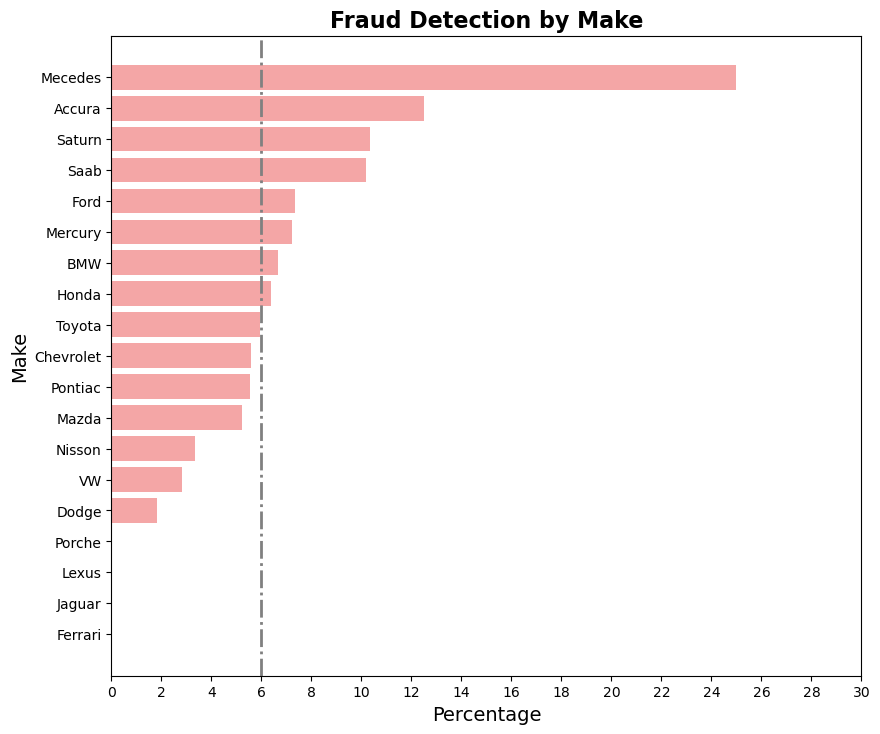

In [171]:
# Plot the Chart
fig, ax = plt.subplots(figsize =(10,8))
x = df_percentages_fraud2['Make']
y = df_percentages_fraud2['Fraud %']

ax.barh(x,y, color ='lightcoral', alpha = 0.7)
ax.set_title('Fraud Detection by Make', fontsize = 16, fontfamily = 'DejaVu Sans', fontweight = 'bold')
ax.set_xlabel('Percentage', fontsize = 14, fontfamily = 'DejaVu Sans')
ax.set_ylabel('Make', fontsize = 14, fontfamily ='DejaVu Sans')
ax.set_xlim(0, 30)
ax.set_xticks(np.arange(0, 31, 2))
ax.axvline(x=6, color='gray', linestyle='dashdot', linewidth=2, alpha=1)

plt.subplots_adjust(left=0.2, right=0.95, top=0.9, bottom=0.1)
plt.show()

##### We can observe that Mecedes owners are more likely to be involved in fraud, with almost double the incidence compared to the second-highest grop, Accura owenrs.

### 05) Fraud Detection by Vehicle Price

In [ ]:
raw_data_price = raw_data['VehiclePrice'].value_counts().sort_index()
fraud_data_price = fraud_data['VehiclePrice'].value_counts().sort_index()

df_percentages_price = pd.DataFrame(round((fraud_data_price / raw_data_price) * 100 , 2)).fillna(0).reset_index()
df_percentages_price = df_percentages_price.rename(columns={'VehiclePrice' : 'Vehicleprice', 'count' : 'Fraud %'})

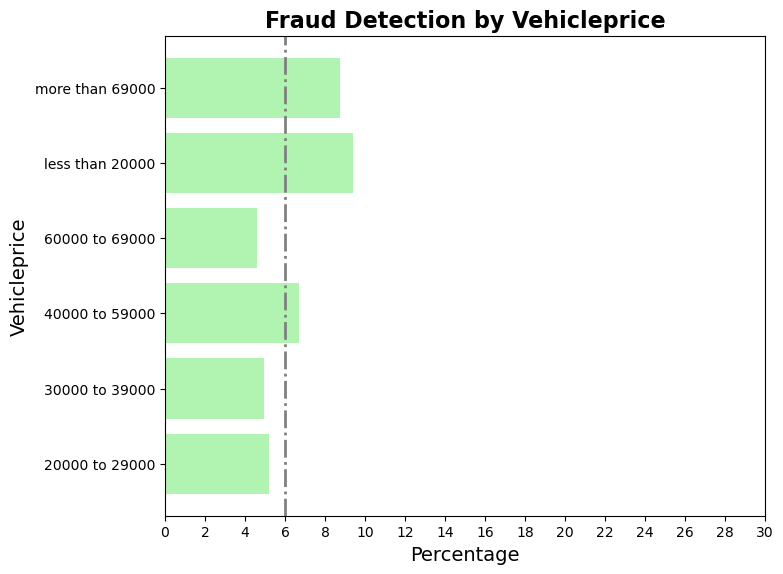

In [192]:
# Plot the Chart
fig, ax = plt.subplots(figsize =(8,6))
x = df_percentages_price['Vehicleprice']
y = df_percentages_price['Fraud %']

ax.barh(x,y, color ='lightgreen', alpha = 0.7)
ax.set_title('Fraud Detection by Vehicleprice', fontsize = 16, fontfamily = 'DejaVu Sans', fontweight = 'bold')
ax.set_xlabel('Percentage', fontsize = 14, fontfamily = 'DejaVu Sans')
ax.set_ylabel('Vehicleprice', fontsize = 14, fontfamily ='DejaVu Sans')
ax.set_xlim(0, 30)
ax.set_xticks(np.arange(0, 31, 2))
ax.axvline(x=6, color='gray', linestyle='dashdot', linewidth=2, alpha=1)

plt.subplots_adjust(left=0.2, right=0.95, top=0.9, bottom=0.1)
plt.show()

### 06) Fraud Detection by BasePolicy & PolicyType

In [202]:
#BasePolicy
raw_data_policy = raw_data['BasePolicy'].value_counts().sort_index()
fraud_data_policy = fraud_data['BasePolicy'].value_counts().sort_index()

df_percentages_policy = pd.DataFrame(round((fraud_data_policy / raw_data_policy) * 100 , 2)).fillna(0).reset_index()
df_percentages_policy = df_percentages_policy.rename(columns={'count' : 'Fraud %'})
df_percentages_policy = df_percentages_policy.sort_values(by='Fraud %')

#PolicyType
raw_data_type = raw_data['PolicyType'].value_counts().sort_index()
fraud_data_type = fraud_data['PolicyType'].value_counts().sort_index()

df_percentages_type = pd.DataFrame(round((fraud_data_type / raw_data_type) * 100 , 2)).fillna(0).reset_index()
df_percentages_type = df_percentages_type.rename(columns={'count' : 'Fraud %'})
df_percentages_type = df_percentages_type.sort_values(by='Fraud %')

In [203]:
df_percentages_type

,PolicyType,Fraud %
3,Sport - All Perils,0.00
5,Sport - Liability,0.00
8,Utility - Liability,0.00
2,Sedan - Liability,0.72
1,Sedan - Collision,6.88
7,Utility - Collision,10.00
0,Sedan - All Perils,10.06
6,Utility - All Perils,12.06
4,Sport - Collision,13.79


[Text(0, 0, 'Sport - All Perils'),
 Text(1, 0, 'Sport - Liability'),
 Text(2, 0, 'Utility - Liability'),
 Text(3, 0, 'Sedan - Liability'),
 Text(4, 0, 'Sedan - Collision'),
 Text(5, 0, 'Utility - Collision'),
 Text(6, 0, 'Sedan - All Perils'),
 Text(7, 0, 'Utility - All Perils'),
 Text(8, 0, 'Sport - Collision')]

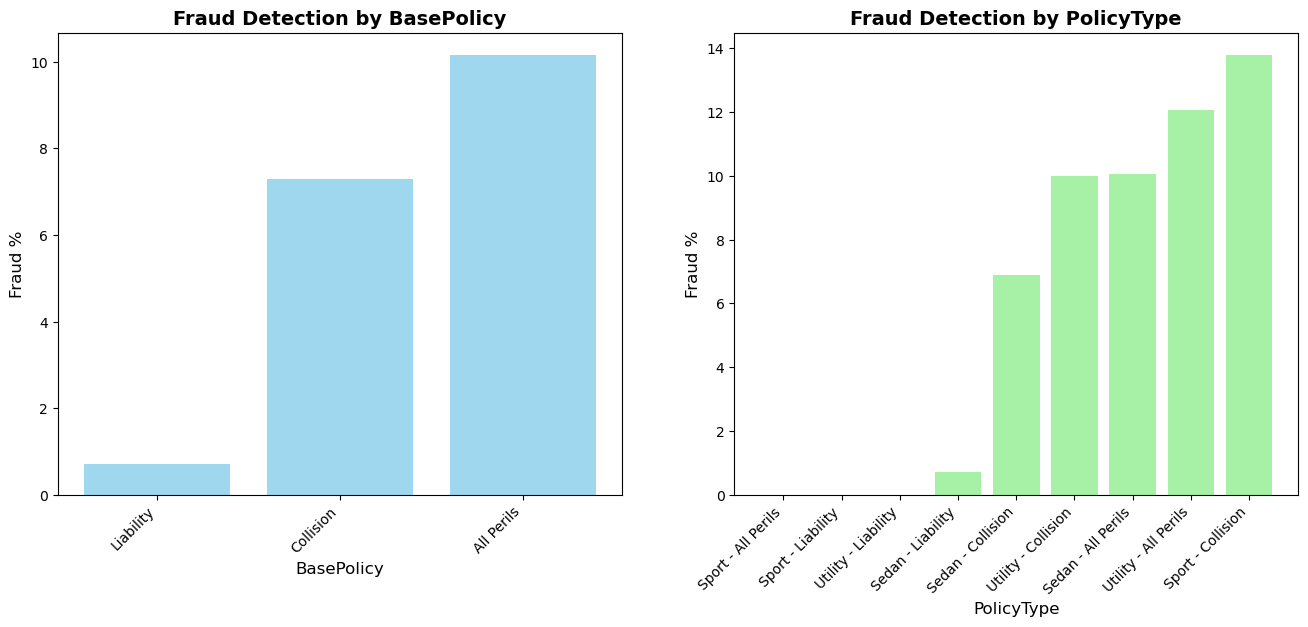

In [204]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# BasePolicy 
axes[0].bar(df_percentages_policy['BasePolicy'], df_percentages_policy['Fraud %'], color='skyblue', alpha=0.8)
axes[0].set_title('Fraud Detection by BasePolicy', fontsize=14, fontweight='bold')
axes[0].set_xlabel('BasePolicy', fontsize=12)
axes[0].set_ylabel('Fraud %', fontsize=12)
axes[0].set_xticks(range(len(df_percentages_policy['BasePolicy'])))
axes[0].set_xticklabels(df_percentages_policy['BasePolicy'], rotation=45, ha='right')

# PolicyType
axes[1].bar(df_percentages_type['PolicyType'], df_percentages_type['Fraud %'], color='lightgreen', alpha=0.8)
axes[1].set_title('Fraud Detection by PolicyType', fontsize=14, fontweight='bold')
axes[1].set_xlabel('PolicyType', fontsize=12)
axes[1].set_ylabel('Fraud %', fontsize=12)
axes[1].set_xticks(range(len(df_percentages_type['PolicyType'])))
axes[1].set_xticklabels(df_percentages_type['PolicyType'], rotation=45, ha='right')

### 07) Fraud Detection by Month & MonthClaimed

In [207]:
#Month
raw_data_Month = raw_data['Month'].value_counts().sort_index()
fraud_data_Month = fraud_data['Month'].value_counts().sort_index()

df_percentages_Month = pd.DataFrame(round((fraud_data_Month / raw_data_Month) * 100 , 2)).fillna(0).reset_index()
df_percentages_Month = df_percentages_Month.rename(columns={'count' : 'Fraud %'})
df_percentages_Month = df_percentages_Month.sort_values(by='Fraud %')

#MonthClaimed
raw_data_Claim = raw_data['MonthClaimed'].value_counts().sort_index()
fraud_data_Claim = fraud_data['MonthClaimed'].value_counts().sort_index()

df_percentages_Claim = pd.DataFrame(round((fraud_data_Claim / raw_data_Claim) * 100 , 2)).fillna(0).reset_index()
df_percentages_Claim = df_percentages_Claim.rename(columns={'count' : 'Fraud %'})
df_percentages_Claim = df_percentages_Claim.sort_values(by='Fraud %')

[Text(0, 0, '0'),
 Text(1, 0, 'Nov'),
 Text(2, 0, 'Dec'),
 Text(3, 0, 'Jul'),
 Text(4, 0, 'Oct'),
 Text(5, 0, 'Jun'),
 Text(6, 0, 'Feb'),
 Text(7, 0, 'Sep'),
 Text(8, 0, 'Jan'),
 Text(9, 0, 'Apr'),
 Text(10, 0, 'Mar'),
 Text(11, 0, 'May'),
 Text(12, 0, 'Aug')]

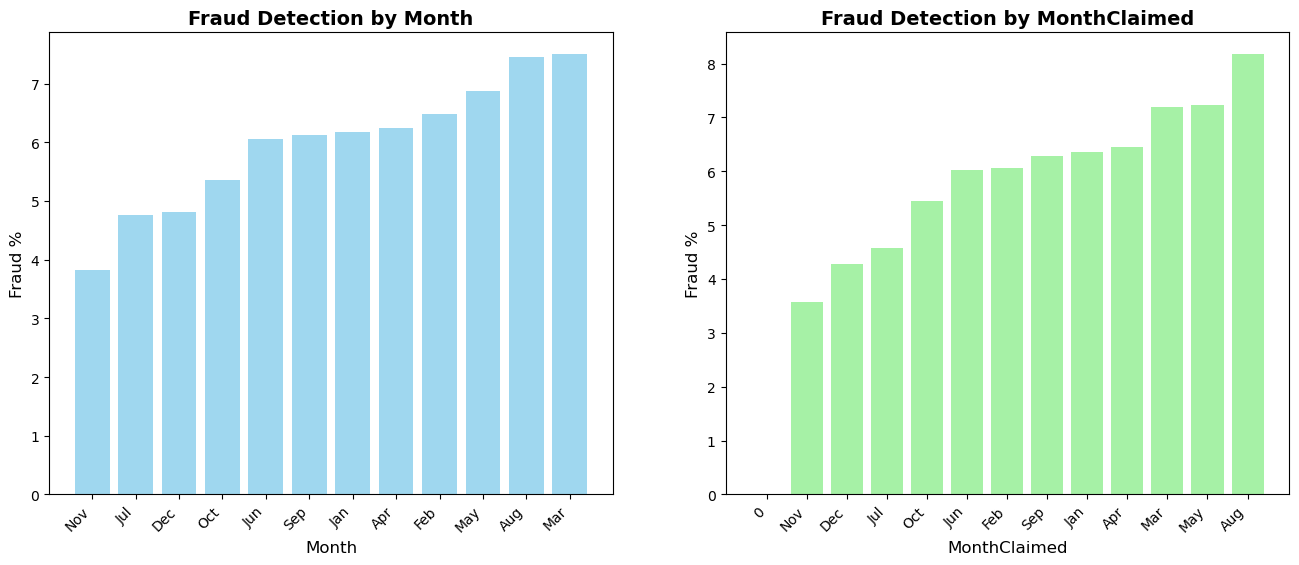

In [210]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Month
axes[0].bar(df_percentages_Month['Month'], df_percentages_Month['Fraud %'], color='skyblue', alpha=0.8)
axes[0].set_title('Fraud Detection by Month', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Month', fontsize=12)
axes[0].set_ylabel('Fraud %', fontsize=12)
axes[0].set_xticks(range(len(df_percentages_Month['Month'])))
axes[0].set_xticklabels(df_percentages_Month['Month'], rotation=45, ha='right')

# MonthClaimed
axes[1].bar(df_percentages_Claim['MonthClaimed'], df_percentages_Claim['Fraud %'], color='lightgreen', alpha=0.8)
axes[1].set_title('Fraud Detection by MonthClaimed', fontsize=14, fontweight='bold')
axes[1].set_xlabel('MonthClaimed', fontsize=12)
axes[1].set_ylabel('Fraud %', fontsize=12)
axes[1].set_xticks(range(len(df_percentages_Claim['MonthClaimed'])))
axes[1].set_xticklabels(df_percentages_Claim['MonthClaimed'], rotation=45, ha='right')

#### The above show that the two columns have similar distribution. So we don't need both. 

### Data Transformation - Encoding Categorical Variables (Binary Vairable) - Label Encoding

#### Our Target : FraudFound-P

In [63]:
raw_data.columns

Index(['Month', 'WeekOfMonth', 'DayOfWeek', 'Make', 'AccidentArea',
       'DayOfWeekClaimed', 'MonthClaimed', 'WeekOfMonthClaimed', 'Sex',
       'MaritalStatus', 'Age', 'Fault', 'PolicyType', 'VehicleCategory',
       'VehiclePrice', 'FraudFound_P', 'PolicyNumber', 'RepNumber',
       'Deductible', 'DriverRating', 'Days_Policy_Accident',
       'Days_Policy_Claim', 'PastNumberOfClaims', 'AgeOfVehicle',
       'AgeOfPolicyHolder', 'PoliceReportFiled', 'WitnessPresent', 'AgentType',
       'NumberOfSuppliments', 'AddressChange_Claim', 'NumberOfCars', 'Year',
       'BasePolicy'],
      dtype='object')

In [64]:
column_list = raw_data.columns

In [65]:
raw_data['FraudFound_P']

0        0
1        0
2        0
3        0
4        0
        ..
15415    1
15416    0
15417    1
15418    0
15419    1
Name: FraudFound_P, Length: 15420, dtype: int64

In [66]:
discrete_column = [col for col in column_list if raw_data[col].dtype == 'object']
binary_columns = [col for col in column_list if (raw_data[col].nunique() == 2) & (col != 'FraudFound_P') ]
print("The number of Binary Columns without target :", len(binary_columns) )
print("list of binary column : " , binary_columns)

The number of Binary Columns without target : 6
list of binary column :  ['AccidentArea', 'Sex', 'Fault', 'PoliceReportFiled', 'WitnessPresent', 'AgentType']


In [67]:
le = LabelEncoder()
df_clean_v1 = raw_data.copy()

for col  in binary_columns:
    df_clean_v1[col] = le.fit_transform(df_clean_v1[col])
    print('Label Mapping: ', dict(zip(le.classes_, le.transform(le.classes_))))

Label Mapping:  {'Rural': 0, 'Urban': 1}
Label Mapping:  {'Female': 0, 'Male': 1}
Label Mapping:  {'Policy Holder': 0, 'Third Party': 1}
Label Mapping:  {'No': 0, 'Yes': 1}
Label Mapping:  {'No': 0, 'Yes': 1}
Label Mapping:  {'External': 0, 'Internal': 1}


#### Data Transformation - Encoding Categorical Variables (Ordinal Categorical Variables & Nominal Categorical Variables) - Label Encoding

- An Ordinal Categorical Variable is a categorical variable where the categories have a logical order or ranking
- A Nominal Categorical Variable is a categorical variable where the categories do not have a logical order or ranking

In [68]:
Ordinal_cat = ['VehiclePrice', 'DriverRating', 'AgeOfVehicle', 'BasePolicy']

In [69]:
for col in Ordinal_cat :
    print(f"The unique values in {col} :",  df_clean_v1[col].unique)

The unique values in VehiclePrice : <bound method Series.unique of 0        more than 69000
1        more than 69000
2        more than 69000
3         20000 to 29000
4        more than 69000
              ...       
15415     20000 to 29000
15416     30000 to 39000
15417     20000 to 29000
15418     20000 to 29000
15419     20000 to 29000
Name: VehiclePrice, Length: 15420, dtype: object>
The unique values in DriverRating : <bound method Series.unique of 0        1
1        4
2        3
3        2
4        1
        ..
15415    4
15416    3
15417    4
15418    4
15419    4
Name: DriverRating, Length: 15420, dtype: int64>
The unique values in AgeOfVehicle : <bound method Series.unique of 0            3 years
1            6 years
2            7 years
3        more than 7
4            5 years
            ...     
15415        6 years
15416        6 years
15417        5 years
15418        2 years
15419        5 years
Name: AgeOfVehicle, Length: 15420, dtype: object>
The unique values in Ba

In [70]:
vehicleprice_label = {'more than 69000': 1, '20000 to 29000': 0,  '30000 to 39000': 0, 'less than 20000': 1, '40000 to 59000': 1, '60000 to 69000': 0}
ageofvehicle_label = {'new': 2, '2 years': 0, '3 years': 2, '4 years': 2, '5 years': 1, '6 years': 1, '7 years': 0, 'more than 7': 0}
basepolicy_label = {'Liability': 0, 'Collision': 1, 'All Perils': 2}

In [ ]:
df_clean_v1['AgeOfVehicle'].unique()

array(['3 years', '6 years', '7 years', 'more than 7', '5 years', 'new',
       '4 years', '2 years'], dtype=object)

In [75]:
df_clean_v1['VehiclePrice'] = df_clean_v1['VehiclePrice'].map(vehicleprice_label)
df_clean_v1['AgeOfVehicle'] = df_clean_v1['AgeOfVehicle'].map(ageofvehicle_label)
df_clean_v1['BasePolicy'] = df_clean_v1['BasePolicy'].map(basepolicy_label)

df_clean_v2 = df_clean_v1.copy()

### Data Reduction - Feature Selection 01(Drop Useless Columns)

In [77]:
useless_columns = ['Month', 'WeekOfMonth', 'DayOfWeek', 'DayOfWeekClaimed', 'WeekOfMonthClaimed', 'PolicyNumber']
df_clean_v3 = df_clean_v2.drop(columns=useless_columns, axis=1)

### Data Transformation - One-hot-Encoding (Other categorical Variables)

In [78]:
dtype_change_string = ['RepNumber', 'Deductible', 'Year']

for col in dtype_change_string:
    df_clean_v3[col] = df_clean_v3[col].astype(str)

In [79]:
onehot_encoding_columns = ['Make', 'MonthClaimed', 'MaritalStatus', 'PolicyType', 'VehicleCategory', 'RepNumber', 'Deductible', 'Days_Policy_Accident', 'Days_Policy_Claim', 'PastNumberOfClaims', 'AgeOfPolicyHolder', 'NumberOfSuppliments', 'AddressChange_Claim', 'NumberOfCars', 'Year']
print("The number of one-hot encoding target features: ", len(onehot_encoding_columns))

The number of one-hot encoding target features:  15


In [80]:
df_clean_v4 = pd.get_dummies(df_clean_v3, columns=onehot_encoding_columns)
df_clean_v4.shape

(15420, 119)

### Data Reduction - Feature Selection 02 (Drop Constant Features)

In [81]:
onehot_encoded_columns = [col for col in df_clean_v4.columns if '_' in col]
onehot_encoded_columns.remove("FraudFound_P")
print("The Number of One-hot Encoded Columns: ", len(onehot_encoded_columns))

The Number of One-hot Encoded Columns:  107


In [82]:
constant_features = []
for col in onehot_encoded_columns:
    if df_clean_v4[col].sum() <= 5:
        constant_features.append(col)
print("The Number of Constant Features: ", len(constant_features))

The Number of Constant Features:  9


In [83]:
df_clean_v4.drop(columns=constant_features, axis=1, inplace=True)
df_clean_v4.shape

(15420, 110)

### Data Cleaning - Correcting Inaccurate Data & Handling Outliers (Age) - Outlier Replacement using LightGBM

In [84]:
# Function02: Outlier Replacement using LightGBM
import lightgbm as lgb

def lightgbm_imputation(dataframe, feature):
    df_copy = dataframe.copy()
    train_data = df_copy[df_copy[feature].notnull()]
    test_data = df_copy[df_copy[feature].isnull()]
    
    X_train = train_data.drop(columns=[feature], axis=1)
    y_train = train_data[feature]
    X_test = test_data.drop(columns=[feature], axis=1)
    
    train_dataset = lgb.Dataset(X_train, label=y_train)
    
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'verbose': -1
    }
    
    model = lgb.train(params, train_dataset, num_boost_round=100)
    
    predictions = model.predict(X_test)
    
    df_copy.loc[df_copy[feature].isnull(), feature] = predictions
    
    return df_copy

In [85]:
# Change 0s and outliers into NullValues
df_clean_v4['Age'] = df_clean_v4['Age'].apply(lambda x: np.nan if x == 0 or x > 74 else x)

In [86]:
# Apply LightGBM Imputation
df_imputed = lightgbm_imputation(df_clean_v4, 'Age')

In [87]:
# Round up floats
df_imputed['Age'] = df_imputed["Age"].apply(lambda x: round(x))

In [88]:
# Function03: Categorize Age
def categorize_age(age):
    if age <= 20:
        return 0
    elif age <= 40:
        return 1
    elif age <= 65:
        return 2
    else:
        return 3

In [89]:
df_imputed['Age'] = df_imputed['Age'].apply(categorize_age)

In [90]:
df_clean_v5 = df_imputed.copy()
df_clean_v5.shape

(15420, 110)

In [93]:
df_clean_v5.to_csv('./our_fraud_data.csv', index= False, encoding = 'utf-8')

In [94]:
pd.read_csv('./our_fraud_data.csv')

,AccidentArea,Sex,Age,Fault,VehiclePrice,FraudFound_P,DriverRating,AgeOfVehicle,PoliceReportFiled,WitnessPresent,...,AddressChange_Claim_2 to 3 years,AddressChange_Claim_4 to 8 years,AddressChange_Claim_no change,NumberOfCars_1 vehicle,NumberOfCars_2 vehicles,NumberOfCars_3 to 4,NumberOfCars_5 to 8,Year_1994,Year_1995,Year_1996
0,1,0,1,0,1,0,1,2,0,0,...,False,False,False,False,False,True,False,True,False,False
1,1,1,1,0,1,0,4,1,1,0,...,False,False,True,True,False,False,False,True,False,False
2,1,1,2,0,1,0,3,0,0,0,...,False,False,True,True,False,False,False,True,False,False
3,0,1,2,1,0,0,2,0,1,0,...,False,False,True,True,False,False,False,True,False,False
4,1,0,1,1,1,0,1,1,0,0,...,False,False,True,True,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15415,1,1,1,0,0,1,4,1,0,0,...,False,False,True,True,False,False,False,False,False,True
15416,1,1,1,0,0,0,3,1,0,0,...,False,False,True,False,False,True,False,False,False,True
15417,0,1,1,0,0,1,4,1,0,0,...,False,False,True,True,False,False,False,False,False,True
15418,1,0,1,1,0,0,4,0,0,0,...,False,False,True,True,False,False,False,False,False,True
